In [1]:
import PIL.Image
import numpy as np
from keras.models import load_model
import tensorflow as tf
import cv2 
import matplotlib.pyplot as plt

In [2]:
#Загрузка моделей
model_car = load_model('Модели\\cars_best.h5')
model_acc = load_model('Модели\\class.h5')
model_loc = load_model('Модели\\loc.h5')
global model_loc
global model_acc
global model_car

In [3]:
#Подготовка изображения 
def _preprocessing_image(image, model):
    image_orig = PIL.Image.open(image)
    image = PIL.Image.open(image)
    image = image.resize((208, 208))
    arr = np.array(image)
    arr = arr.reshape(1, 208, 208, 3)
    a,b = image_orig.size[0],image_orig.size[1]
    #Получаем коэффициенты
    ratio_x, ratio_y = a / 208, b / 208
    ratio = (ratio_x,ratio_y)
    image_orig = np.array(image_orig)
    image_orig = image_orig.reshape(1,b,a,3)
    predictions = model.predict(arr)
    
    return arr, predictions,image_orig, ratio

In [4]:
def predict(name):
    # функция приводит данные в надлежащий вид
    x_car,y_car,img, ratio = _preprocessing_image(name, model_car)
    x_acc,y_acc,img, ratio = _preprocessing_image(name, model_acc)
    # предсказания модели
    if (100 - round((y_car[0][0]) * 100) > 30) and (y_acc[0][0]*100>=25): return (1,'Обнаружена авария',img)
    elif (100 - round((y_car[0][0]) * 100) < 30): return (2,'Ничего не обнаружено',img)
    elif (100 - round((y_car[0][0]) * 100) > 30) and not(y_acc[0][0]*100>=25): return (0,'Обнаружена машина',img)

In [5]:
def predict_bounding_box(image):
    img_class, dtype, img = predict(image)
    images, prediction, img, ratio = _preprocessing_image(image, model_loc)
    images = np.array(img)
    prediction = np.array(prediction)
    if img_class == 0: 
        print(dtype)
        bounding_box(images,prediction,(0,255,0),'Car', ratio)
    elif img_class == 1:
        print(dtype)
        bounding_box(images,prediction,(0,0,255),'Accidents', ratio)
    elif img_class == 2:
        print(dtype)
        bounding_box(images,dtype = True)

In [6]:
def bounding_box(images, prediction = None,frame = None,text = None, ratio = None, dtype = None):
    if dtype is None:
            #Для машины или аварии
        ratio_x, ratio_y = ratio
        if ratio_x*ratio_y < 3.3: 
            thich = 1
            txt = 0.3
        elif 6.6 > ratio_x*ratio_y >= 4.4: 
            thich = 2 
            txt = 1
        else:
            thich = 3 
            txt = 3
        for i, pred in enumerate(images):
            x, y, w, h = prediction[i]
            b,g,r=cv2.split(pred)
            pred=cv2.merge((r,g,b)) 
            cv2.rectangle(pred, (int(x*ratio_x), int(y*ratio_y)), (int(w*ratio_x), int(h*ratio_y)), frame, thich) #Отрисовка рамки
            cv2.putText(pred,text,(int(x*ratio_x), int(y*ratio_y-2)),cv2.FONT_HERSHEY_DUPLEX,txt,frame,thich,100) #Отрисовка текста
            plt.figure(figsize=(10,10))
            plt.imshow(pred[:,:,::-1])
    else:
            #Для других объектов
        for i, pred in enumerate(images):
            b,g,r=cv2.split(pred)
            pred=cv2.merge((r,g,b))
            plt.figure(figsize=(10,10))
            plt.imshow(pred[:,:,::-1])

Ничего не обнаружено


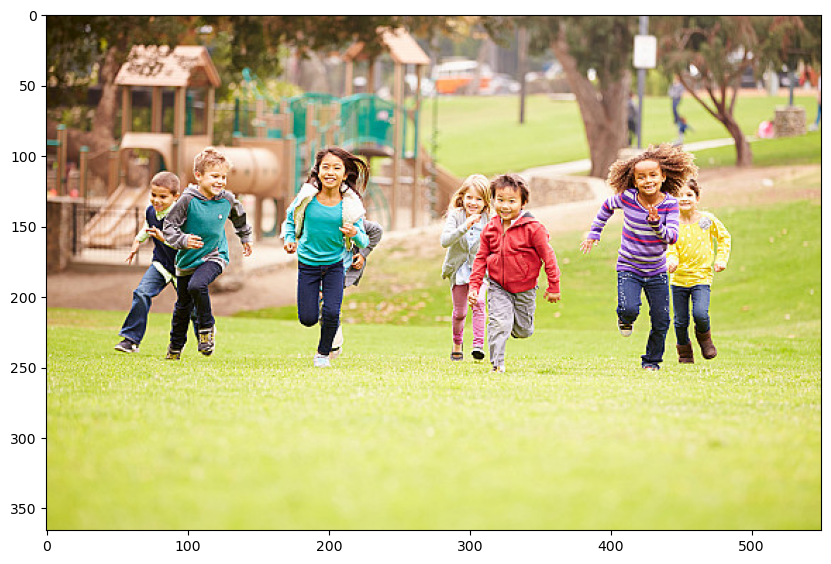

In [7]:
#Ничего
predict_bounding_box('C:\\Users\\Matvey\\Downloads\\проверка\\iStock-494239087-thumb.jpg')

Обнаружена машина


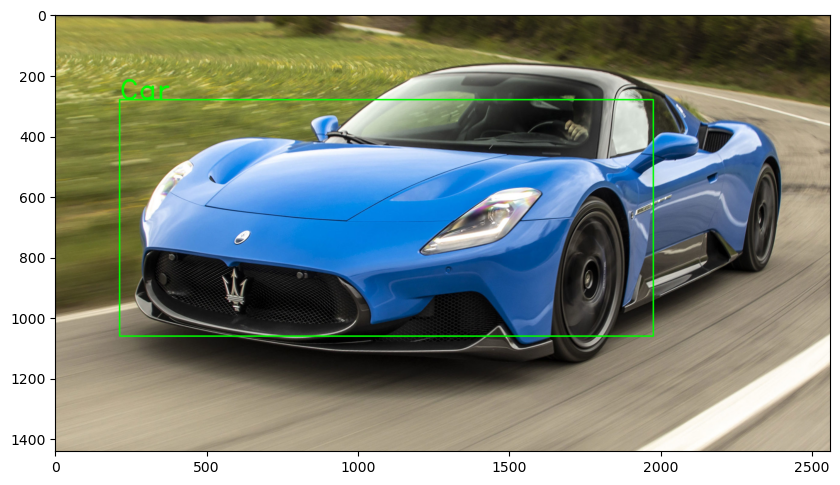

In [8]:
#Машина
predict_bounding_box('C:\\Users\\Matvey\\Downloads\\проверка\\18015-MC20BluInfinito-scaled-e1666008987698.jpg')

Обнаружена авария


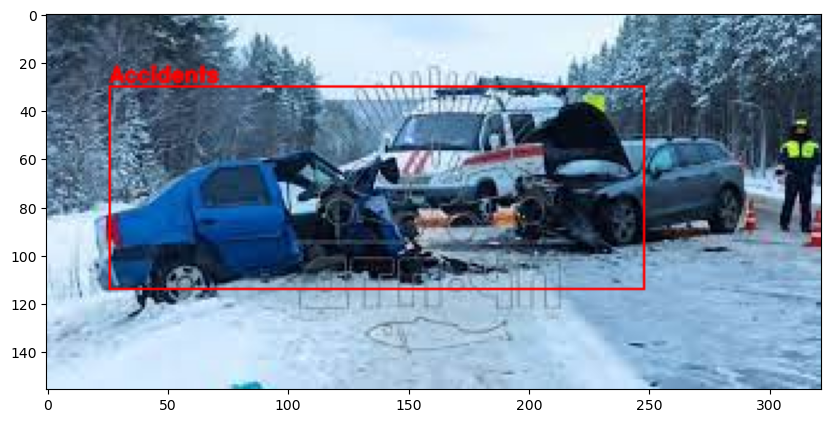

In [9]:
#Авария
predict_bounding_box('C:\\Users\\Matvey\\Downloads\\проверка\\Без названия11.jpg')